# Scikit Learn Pipelines

We’ve reached an important step. Make sure to review this notebook regularly. We’ll pull together everything we’ve learned so far.

We’ll start by importing what we need and explain them as we go.

In [25]:
# Importing Pandas
import pandas as pd

# Preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# Pipeline tools
from sklearn.pipeline import Pipeline  # Chains transformations in sequence
from sklearn.compose import ColumnTransformer  # Applies transformations to specific columns in parallel
from sklearn.preprocessing import FunctionTransformer  # Makes custom functions work in pipelines

# Classification model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

Now's a good time to check which version of scikit-learn we’re using.

In [26]:
import sklearn
sklearn.__version__

'1.5.1'

Contents:

- [The Titanic disaster](#1.-The-Titanic-disaster)
- [Custom transformers: creating new features](#2.-Custom-transformers:-creating-new-features)
- [Column transformers and pipelines](#3.-Column-transformers-and-pipelines)
- [Building the classification pipeline](#4.-Building-the-classification-pipeline)
- [Hyperparameter tuning with grid search](#5.-Hyperparameter-tuning-with-grid-search)
- [Evaluating the model](#6.-Evaluating-the-model)
- [Would your professor have survived the Titanic disaster?](#7.-Would-your-professor-have-survived-the-Titanic-disaster?)

## 1. The Titanic disaster

We'll be using the Titanic dataset. This dataset includes information about passengers on the Titanic, such as their age, gender, class, and whether they survived

In [27]:
path = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/titanic.csv'
df = pd.read_csv(path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Column Name    | Description |
|----------------|-------------|
| **PassengerId** | Unique ID for each passenger |
| **Survived**    | Survival (0 = No, 1 = Yes) |
| **Pclass**      | Passenger class (1st, 2nd, 3rd) |
| **Name**        | Name of the passenger |
| **Sex**         | Gender of the passenger |
| **Age**         | Age of the passenger |
| **SibSp**       | Number of siblings/spouses aboard |
| **Parch**       | Number of parents/children aboard |
| **Ticket**      | Ticket number |
| **Fare**        | Ticket fare |
| **Cabin**       | Cabin number |
| **Embarked**    | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

Our goal is to predict if a passenger survived the Titanic disaster or not.

## 2. Custom transformers: creating new features

Often, you’ll want to create new features from your existing data to improve your model's performance. 
For example, you might combine or transform existing columns into new ones. 
To do this in a pipeline, you can use `FunctionTransformer`, which lets you wrap any Python function and apply it as a transformer. 
This makes it easy to generate new features during the data preprocessing step.

We'll illustrate this with two examples. We'll create two new features: Title (e.g., Dr., Mr., Rev.) and Family Size.

**Title** can give insight into a passenger’s social status or profession, which could influence their likelihood of survival.
**Family Size** combines the number of siblings, spouses, parents, and children a passenger had on board. 
This might help because passengers with larger families could have different survival chances compared to those traveling alone."

These are just examples of new features I came up with. Can you think of other features that might improve our predictions?

**Title Feature**: Let's write a function to extract the title (Mr., Mrs., Miss, Dr., etc.) from the passenger's name.

In [28]:
# Let's take a look at the names
df.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

To extract the title from the passenger's name, we can use the fact that titles like "Mr.", "Mrs.", and "Dr." typically appear between the first and last names. We’ll use string manipulation methods to locate the title. One way is to split the name by commas and then extract the part that contains the title.

In [29]:
# Here’s an example:
df.Name[0].split(',')[1].split('.')[0].strip()

'Mr'

In [30]:
# check that our idea works
df['Name'].apply(lambda name:name.split(',')[1].split('.')[0].strip())

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object

Some titles appear very infrequently, and we’ll need to handle them appropriately. We’ll discuss how to deal with these later.

In [53]:
# check that our idea works
df['Name'].apply(lambda name:name.split(',')[1].split('.')[0].strip() ).value_counts(normalize=True)

Name
Mr              0.580247
Miss            0.204265
Mrs             0.140292
Master          0.044893
Dr              0.007856
Rev             0.006734
Mlle            0.002245
Major           0.002245
Col             0.002245
the Countess    0.001122
Capt            0.001122
Ms              0.001122
Sir             0.001122
Lady            0.001122
Mme             0.001122
Don             0.001122
Jonkheer        0.001122
Name: proportion, dtype: float64

In [32]:
def get_title(dataframe):
    # Step 1: Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Step 2: Extract the title from the 'Name' column
    df['Title'] = df.Name.apply(lambda x: x.split(",")[1].split(".")[0].strip())
    return df

In [33]:
# Check if the function works
get_title(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


**Family Size Feature:** Let’s write a function to calculate the size of a passenger’s family.

To get the family size, we add the number of siblings/spouses (SibSp), parents/children (Parch), and include the passenger (add 1).

In [34]:
# family size
family_size = df.SibSp+df.Parch+1
family_size

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Length: 891, dtype: int64

In [35]:
def get_family_size(dataframe):
    # Make a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Calculate family size by adding SibSp (siblings/spouses) and Parch (parents/children), then add 1 for the passenger
    df['Family_size'] = df.SibSp + df.Parch + 1
    return df

In [36]:
# check that it works
get_family_size(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


Now that we have the two functions, `get_title` and `get_family_size`, we can easily apply them to our data using `FunctionTransformer`. This allows us to wrap the functions and use them as part of our data processing steps.

In [37]:
# Wrapping functions for use in preprocessing
family_size_processor = FunctionTransformer(get_family_size)
title_processor = FunctionTransformer(get_title)

And here’s the cool part: now our family size and title processors work just like any other scikit-learn transformer. They come with the `.fit`, `.transform`, and `.fit_transform` methods.

In [38]:
family_size_processor.fit_transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [39]:
title_processor.fit_transform(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


Let’s set these functions aside for now. We’ll come back to them later, but for now, let’s switch gears.

 ## 3. Column transformers and pipelines

Often, we need to apply different transformations to different types of columns. That’s where `ColumnTransformer` comes in. 
It allows us to handle each group of columns separately.
We’ll create one transformer for the numerical features, another for the categorical features, and a third for the ordinal features. This way, we can customize how each type of data is processed

Each feature transformer will actually be a `pipeline`, where we chain together the processing steps for that feature group. 
This allows us to apply multiple transformations in sequence—one after the other. 
For example, we can handle missing values, scale the data, and apply any custom transformations, all within a single pipeline for each set of features.

In scikit-learn, a **pipeline** is a sequence of steps where each step has a name and an operation (like a transformation or model).
The data moves through the steps in order. 
Each step has:

- Name: A label for the step.
- Operation: The transformation or model to apply.
  
The pipeline runs everything in sequence, so you don’t have to apply each step separately.

Let’s create a pipeline for the numerical features. First, we’ll handle missing values by imputing them, then we’ll scale the data.

In [40]:
# Pipeline for numerical features: impute missing values and scale
numeric_features = ['Age', 'Fare', 'Family_size', 'Pclass']
numeric_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values using the median
    ('scaler', StandardScaler())  # Scale the data
])
numeric_processor

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

Next, we’ll create one more pipeline for the categorical features. We’ll handle missing values and then apply the appropriate transformations.

In [41]:
# Pipeline for categorical features: impute missing values and apply one-hot encoding
categorical_features = ['Embarked', 'Sex', 'Title']
categorical_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent category
    ('encoder', OneHotEncoder(min_frequency=0.01, handle_unknown='ignore'))  # One-hot encode categorical data
])

- **min_frequency=0.01**: This handles the very infrequent titles we saw earlier by grouping them as 'other.' Only categories that appear in at least 1% of the data get their own column.

- **handle_unknown='ignore'**: Any unseen categories during prediction are ignored to avoid errors.

In [42]:
categorical_processor

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', min_frequency=0.01))])

A **ColumnTransformer** allows you to apply different transformations to specific columns in a dataset. You define a list of transformations, where each transformation has:

- A **name**: A label for that transformation.
- A **transformer**: The operation you want to apply (e.g., scaling, encoding).
- The **columns**: The specific columns you want to transform.

For example, if you want to combine our two processors:

In [43]:
feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)
    ],
         remainder='drop') # drop 'Name', 'SibSp', 'Parch' columns

feature_processor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Fare', 'Family_size', 'Pclass']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01))]),
                                 ['Embarked', 'Sex', 'Title'])])

## 4. Building the classification pipeline

Now, let’s bring everything together. We'll build a pipeline that:

1. Creates the family size feature.
2. Extracts the title feature.
3. Processes numerical and categorical features separately.
4. Adds polynomial features.
5. Finally, includes a kNN model for making predictions

In [44]:
pipe = Pipeline(steps=[('get family_size', family_size_processor),
                           ('get title', title_processor),
                           ('preprocessor', feature_processor),
                           ('poly_features', PolynomialFeatures()), # add polynomial combinations of the features
                           ('clf', KNeighborsClassifier())   
                          ])
pipe

Pipeline(steps=[('get family_size',
                 FunctionTransformer(func=<function get_family_size at 0x00000233794C3EC0>)),
                ('get title',
                 FunctionTransformer(func=<function get_title at 0x000002337929A0C0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Family_size',
                                                   'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.01))]),
                                                  ['Embarked', 'Sex',
                                                   'Title'])])),
                ('poly_features', PolynomialFeatures()),
                ('clf', KNeighborsClassifier())])

## 5. Hyperparameter tuning with grid search

In [45]:
# Feature matrix and target vector
feature_cols = ['Name','Age','Fare','Sex','Embarked','Pclass','SibSp','Parch']
X = df[feature_cols] 
y = df.Survived

In [46]:
# train/test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

We want to tune the hyperparameters of the kNN model, specifically `weights` and `n_neighbors`.
However, since the kNN model is just one step in a larger pipeline, we need to specify the names of these hyperparameters in a way that the pipeline can recognize them. 

The `__` (double underscore) notation in scikit-learn is used to access the hyperparameters of a specific step within a pipeline. 
When you want to tune a hyperparameter of a model that is part of a pipeline, you need to specify the step name followed by the hyperparameter name, separated by a double underscore.

So, to access the `n_neighbors` hyperparameter of a kNN model within a pipeline, you would write it as `clf__n_neighbors`. Similarly, to access the weights hyperparameter, you would write `clf__weights`.

In [47]:
pipe

Pipeline(steps=[('get family_size',
                 FunctionTransformer(func=<function get_family_size at 0x00000233794C3EC0>)),
                ('get title',
                 FunctionTransformer(func=<function get_title at 0x000002337929A0C0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Family_size',
                                                   'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.01))]),
                                                  ['Embarked', 'Sex',
                                                   'Title'])])),
                ('poly_features', PolynomialFeatures()),
                ('clf', KNeighborsClassifier())])

In [70]:
param_grid = { 
    'clf__n_neighbors': list(range(1,25,2)),
    'clf__weights' : ['uniform','distance'],
    'poly_features__degree' : [1,2],
    #'preprocessor__cat__encoder__min_frequency' : [0.01, 0.005, 0.002]
}

In [71]:
# instantiate and fit the grid
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('get family_size',
                                        FunctionTransformer(func=<function get_family_size at 0x00000233794C3EC0>)),
                                       ('get title',
                                        FunctionTransformer(func=<function get_title at 0x000002337929A0C0>)),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardS...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=0.01))]),
                                                                         ['Embarked',
                                                                          'Sex',
                                                                          'Title'])])),
                                       ('poly_features', PolynomialFeatures()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23],
                         'clf__weights': ['uniform', 'distance'],
                         'poly_features__degree': [1, 2]},
             scoring='accuracy', verbose=1)

In [75]:
# best hyper-parameters
grid.best_params_

{'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'poly_features__degree': 1}

In [76]:
###### best accuracy
grid.best_score_

0.8383084577114428

In [77]:
# best predictor
best_clf = grid.best_estimator_

## 6. Evaluating the model

In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [67]:
y_test_pred = best_clf.predict(X_test)

In [68]:
confusion_matrix(y_test,y_test_pred)

array([[114,  26],
       [ 27,  56]], dtype=int64)

In [69]:
accuracy_score(y_test,y_test_pred)

0.7623318385650224

## 7. Would your professor have survived the Titanic disaster?

In [32]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [79]:
Javier = pd.DataFrame({
                    'Name':['Perez-Alvaro, Dr. Javier'],
                    'Age': [39],
                    'Fare': [13],
                    'Sex': ['male'],
                    'Embarked': ['C'],
                    'Pclass':[2],
                    'SibSp': [1],
                    'Parch': [0],
                   })
Javier

,Name,Age,Fare,Sex,Embarked,Pclass,SibSp,Parch
0,"Perez-Alvaro, Dr. Javier",39,13,male,C,2,1,0


In [80]:
#  0 = No, 1 = Yes
best_clf.predict(Javier) # Oops...

array([0], dtype=int64)

## Decision Tree

Same pipeline, but this time we will use a decision tree.

In [81]:
# Pipeline for numerical features: impute missing values and scale
numeric_features = ['Age', 'Fare', 'Family_size', 'Pclass']
numeric_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values using the median
    #('scaler', StandardScaler())  # Scale the data
])


# Pipeline for categorical features: impute missing values and apply one-hot encoding
categorical_features = ['Embarked', 'Sex', 'Title']
categorical_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent category
    ('encoder', OneHotEncoder(min_frequency=0.01, handle_unknown='ignore'))  # One-hot encode categorical data
])


feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)
    ],
         remainder='drop') # drop 'Name', 'SibSp', 'Parch' columns


In [82]:
pipe = Pipeline(steps=[('get family_size', family_size_processor),
                           ('get title', title_processor),
                           ('preprocessor', feature_processor),
                           ('poly_features', PolynomialFeatures(degree=1)), # add polynomial combinations of the features
                           ('clf', DecisionTreeClassifier())   
                          ])
pipe

Pipeline(steps=[('get family_size',
                 FunctionTransformer(func=<function get_family_size at 0x00000233794C3EC0>)),
                ('get title',
                 FunctionTransformer(func=<function get_title at 0x000002337929A0C0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Fare', 'Family_size',
                                                   'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.01))]),
                                                  ['Embarked', 'Sex',
                                                   'Title'])])),
                ('poly_features', PolynomialFeatures(degree=1)),
                ('clf', DecisionTreeClassifier())])

In [83]:
from sklearn.model_selection import RandomizedSearchCV

In [84]:
param_grid = {
    'poly_features__degree' : [1,2],
    'clf__max_depth': range(1,5),
    'clf__min_samples_split': range(5,50,2),
    'clf__min_samples_leaf': range(5,50,2),
    'clf__max_leaf_nodes': [None, 10, 20, 30,50],
    'clf__max_features': [None, 'sqrt', 'log2']
}

In [85]:
# Set up the RandomizedSearchCV
grid = RandomizedSearchCV(pipe, 
                          param_grid,
                          n_iter=200, 
                          cv=5, 
                          scoring='accuracy', 
                          verbose=1, 
                          n_jobs=-1)

# Fit the randomized search to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('get family_size',
                                              FunctionTransformer(func=<function get_family_size at 0x00000233794C3EC0>)),
                                             ('get title',
                                              FunctionTransformer(func=<function get_title at 0x000002337929A0C0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['Age',
                                                                                'Fare...
                                              PolynomialFeatures(degree=1)),
                                             ('clf',
                                              DecisionTreeClassifier())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'clf__max_depth': range(1, 5),
                                        'clf__max_features': [None, 'sqrt',
                                                              'log2'],
                                        'clf__max_leaf_nodes': [None, 10, 20,
                                                                30, 50],
                                        'clf__min_samples_leaf': range(5, 50, 2),
                                        'clf__min_samples_split': range(5, 50, 2),
                                        'poly_features__degree': [1, 2]},
                   scoring='accuracy', verbose=1)

In [90]:
grid.best_params_

{'poly_features__degree': 2,
 'clf__min_samples_split': 35,
 'clf__min_samples_leaf': 25,
 'clf__max_leaf_nodes': 50,
 'clf__max_features': None,
 'clf__max_depth': 3}

In [91]:
best_clf  = grid.best_estimator_

In [92]:
y_test_pred = best_clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7892376681614349

In [93]:
best_clf.classes_

array([0, 1], dtype=int64)

In [94]:
best_clf['clf']

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=50, min_samples_leaf=25,
                       min_samples_split=35)

In [95]:
feature_names = best_clf['poly_features'].get_feature_names_out(best_clf['preprocessor'].get_feature_names_out())
feature_names

array(['1', 'num__Age', 'num__Fare', 'num__Family_size', 'num__Pclass',
       'cat__Embarked_C', 'cat__Embarked_Q', 'cat__Embarked_S',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Title_Master',
       'cat__Title_Miss', 'cat__Title_Mr', 'cat__Title_Mrs',
       'cat__Title_infrequent_sklearn', 'num__Age^2',
       'num__Age num__Fare', 'num__Age num__Family_size',
       'num__Age num__Pclass', 'num__Age cat__Embarked_C',
       'num__Age cat__Embarked_Q', 'num__Age cat__Embarked_S',
       'num__Age cat__Sex_female', 'num__Age cat__Sex_male',
       'num__Age cat__Title_Master', 'num__Age cat__Title_Miss',
       'num__Age cat__Title_Mr', 'num__Age cat__Title_Mrs',
       'num__Age cat__Title_infrequent_sklearn', 'num__Fare^2',
       'num__Fare num__Family_size', 'num__Fare num__Pclass',
       'num__Fare cat__Embarked_C', 'num__Fare cat__Embarked_Q',
       'num__Fare cat__Embarked_S', 'num__Fare cat__Sex_female',
       'num__Fare cat__Sex_male', 'num__Fare cat__Title_Master'

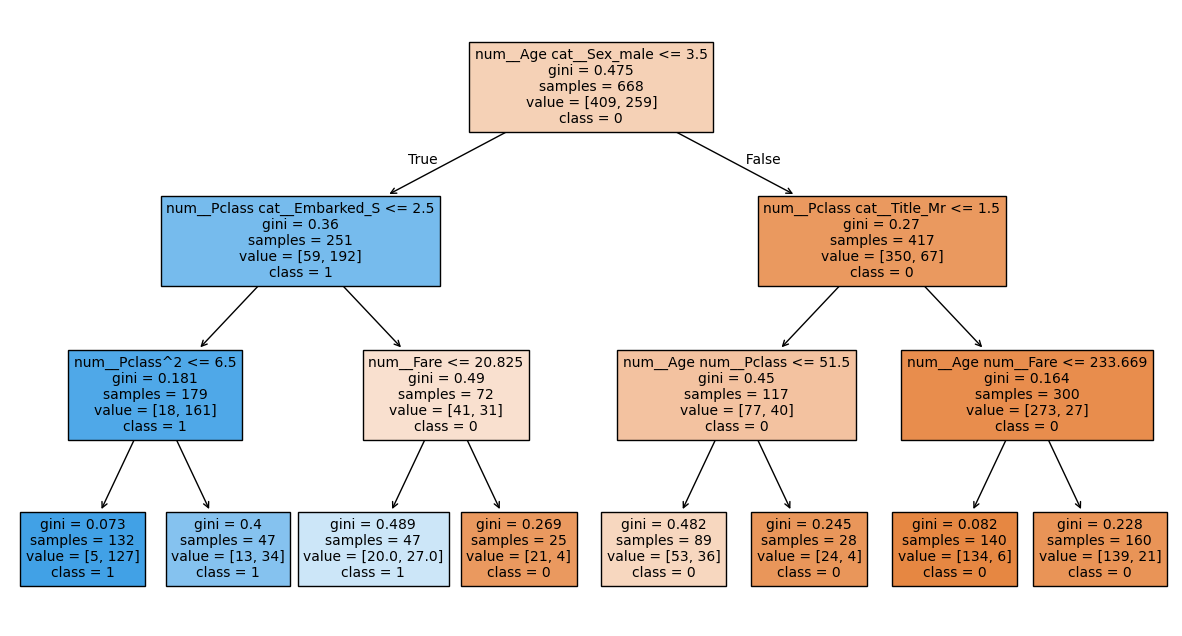

In [96]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plot_tree(best_clf['clf'], 
          feature_names=feature_names, 
          class_names = ['0','1'], 
          filled=True, 
          fontsize=10)
plt.show()

In [97]:
#  0 = No, 1 = Yes
Javier = pd.DataFrame({
                    'Name':['Perez-Alvaro, Dr. Javier'],
                    'Age': [38],
                    'Fare': [100],
                    'Sex': ['male'],
                    'Embarked': ['C'],
                    'Pclass':[1],
                    'SibSp': [1],
                    'Parch': [0],
                   })
best_clf.predict(Javier) # 

array([0], dtype=int64)